In [21]:
import pandas as pd
import numpy as np
df = pd.read_csv("train.csv")
from IPython.display import display
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 20)
display(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [23]:
# === Feature Engineering ===
# 1. Extract raw title from passenger name
df['Raw_Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip() if isinstance(x, str) else np.nan)
print("Unique raw titles:", df['Raw_Title'].unique())

# 2. Normalize titles into broader groups
def normalize_title(raw):
    if raw in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Dr']:
        return 'Mr'
    elif raw in ['Countess', 'Mme']:
        return 'Mrs'
    elif raw in ['Mlle', 'Ms']:
        return 'Miss'
    else:
        return raw

# Apply normalization
df['Title'] = df['Raw_Title'].apply(normalize_title)

# Fix Dr handling by gender
df.loc[(df['Raw_Title'] == 'Dr') & (df['Sex'] == 'female'), 'Title'] = 'Mrs'
df.loc[(df['Raw_Title'] == 'Dr') & (df['Sex'] == 'male'), 'Title'] = 'Mr'
display(df)

Unique raw titles: ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Raw_Title,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev,Mr
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr,Mr


In [30]:
# 3. Fill missing Cabin values and extract deck. In the cabin column, the data is messy
#Some values are like C345 D342 whereas some passengers have repeated cabins. Some values are missing
#Some cabins are on rare decks (like T). #Some rows are a mix of letters and numbers
#So we need a way to pull out whichever deck letter exists inside the string.

def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if substring in big_string:
            return substring
    return np.nan


cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G']
df['Cabin'] = df['Cabin'].fillna('Unknown') #if value is missing, fill with unknown
df['Deck'] = df['Cabin'].apply(lambda x: substrings_in_string(x, cabin_list))
df['Deck'] = df['Deck'].fillna('Unknown')

#Deck letter is highly predictive of survival
#Historically: Decks A–C were mostly 1st class. Decks E–G were closer to lower decks
#Lower decks flooded faster → lower survival rates
#Women/children in 1st class (upper decks) had higher survival

display(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Raw_Title,Title,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,Mr,Mr,Unknown
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss,Miss,Unknown
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,Mr,Mr,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,Unknown,S,Rev,Mr,Unknown
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss,Miss,B
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,Unknown,S,Miss,Miss,Unknown
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr,Mr,C


In [32]:
# 4. Family size
df['Family_Size'] = df['SibSp'] + df['Parch']

# 5. Interaction term: Age * Class
df['Age*Class'] = df['Age'] * df['Pclass']
#we are binding two risk factors together here. higher value means that they are older
#and/or belonging to a lower SEC. 

# 6. Fare per person
df['Fare_Per_Person'] = df['Fare'] / (df['Family_Size'] + 1)

# === Inspect engineered features ===
print(df[['Raw_Title', 'Title', 'Deck', 'Family_Size', 'Age*Class', 'Fare_Per_Person']].head())

  Raw_Title Title     Deck  Family_Size  Age*Class  Fare_Per_Person
0        Mr    Mr  Unknown            1       66.0          3.62500
1       Mrs   Mrs        C            1       38.0         35.64165
2      Miss  Miss  Unknown            0       78.0          7.92500
3       Mrs   Mrs        C            1       35.0         26.55000
4        Mr    Mr  Unknown            0      105.0          8.05000


In [34]:
#Defining target and feature set

target = 'Survived'

features = [
    'Pclass',
    'Sex',
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Embarked',
    'Title',
    'Deck',
    'Family_Size',
    'Age*Class',
    'Fare_Per_Person'
]

X = df[features]
y = df[target]

In [44]:
# Inspect numeric columns BEFORE data imputation
numeric_features = [
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Family_Size',
    'Age*Class',
    'Fare_Per_Person',
    'Pclass'
]
categorical_features = ['Title', 'Sex', 'Embarked', 'Deck']

# 1. Summary statistics (mean, median = 50%, std, min, max)
#    Use this to compare mean vs median differences.
print("=== Summary Statistics (use to compare mean vs median) ===")
print(df[numeric_features].describe())

# 2. Skewness of each numeric column
#    Interpretation:
#    - Skew < 0.5: roughly symmetric → mean imputation is okay
#    - Skew 0.5–1.0: mildly skewed → median safer
#    - Skew > 1.0: strongly skewed → use median
print("\n=== Skewness of Numeric Columns (decide mean vs median) ===")
print(df[numeric_features].skew())

# 3. Check for outliers using IQR (Interquartile Range)
#    High outlier counts suggest median is safer.
Q1 = df[numeric_features].quantile(0.25)
Q3 = df[numeric_features].quantile(0.75)
IQR = Q3 - Q1

outlier_mask = (df[numeric_features] < (Q1 - 1.5 * IQR)) | \
               (df[numeric_features] > (Q3 + 1.5 * IQR))

print("\n=== Outlier Count per Column (median handles outliers better) ===")
print(outlier_mask.sum())

#in some cases, it might make sense to use the mean but just stick to using the 
#median as it the most stable in most cases. the mean is not as stable but more as
#interpretable. in this dataset, 'age' is an example of a feature that can be imputed 
#with the mean. 

=== Summary Statistics (use to compare mean vs median) ===
              Age       SibSp       Parch        Fare  Family_Size  \
count  714.000000  891.000000  891.000000  891.000000   891.000000   
mean    29.699118    0.523008    0.381594   32.204208     0.904602   
std     14.526497    1.102743    0.806057   49.693429     1.613459   
min      0.420000    0.000000    0.000000    0.000000     0.000000   
25%     20.125000    0.000000    0.000000    7.910400     0.000000   
50%     28.000000    0.000000    0.000000   14.454200     0.000000   
75%     38.000000    1.000000    0.000000   31.000000     1.000000   
max     80.000000    8.000000    6.000000  512.329200    10.000000   

        Age*Class  Fare_Per_Person      Pclass  
count  714.000000       891.000000  891.000000  
mean    61.938151        19.916375    2.308642  
std     34.379609        35.841257    0.836071  
min      0.920000         0.000000    1.000000  
25%     38.000000         7.250000    2.000000  
50%     58.00000

In [46]:
#using the decision tree. 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# Convert each category into a one-hot binary column
    # handle_unknown='ignore' prevents errors if unseen categories appear in test data

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)
# Combine both transformers so that numeric and categorical columns
# get processed separately but within ONE unified preprocessing object

model = DecisionTreeClassifier(max_depth=4, random_state=42)
# max_depth limits complexity → prevents overfitting
# random_state ensures reproducibility. Reproducibility means that In ML, many things contain randomness:
#how the model initializes splits, how data is shuffled, how random subsets of features are chosen (Random Forest)
# how samples are selected (bagging/boosting).

#Why random_state=42 exists

#So:
#1. the same train/valid split is created
#2. the same tree decisions are made
#3. the same performance metrics appear

clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', model),
])

In [48]:
# ===========================================
# Train / Validation Split + Model Training
# ===========================================

# Split the dataset into training and validation sets
# test_size=0.2 → 20% of data used to evaluate model performance
# stratify=y → maintains the same Survived/dead ratio in both train and test
X_train, X_valid, y_train, y_valid = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42,  # reproducibility
    stratify=y
)

# Fit the full pipeline on the training data
clf.fit(X_train, y_train)

# Predict on the validation set
y_pred = clf.predict(X_valid)

# Evaluate accuracy
print("Validation Accuracy:", accuracy_score(y_valid, y_pred))

# More detailed evaluation
print("\nClassification Report:\n", classification_report(y_valid, y_pred))


Validation Accuracy: 0.8156424581005587

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       110
           1       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



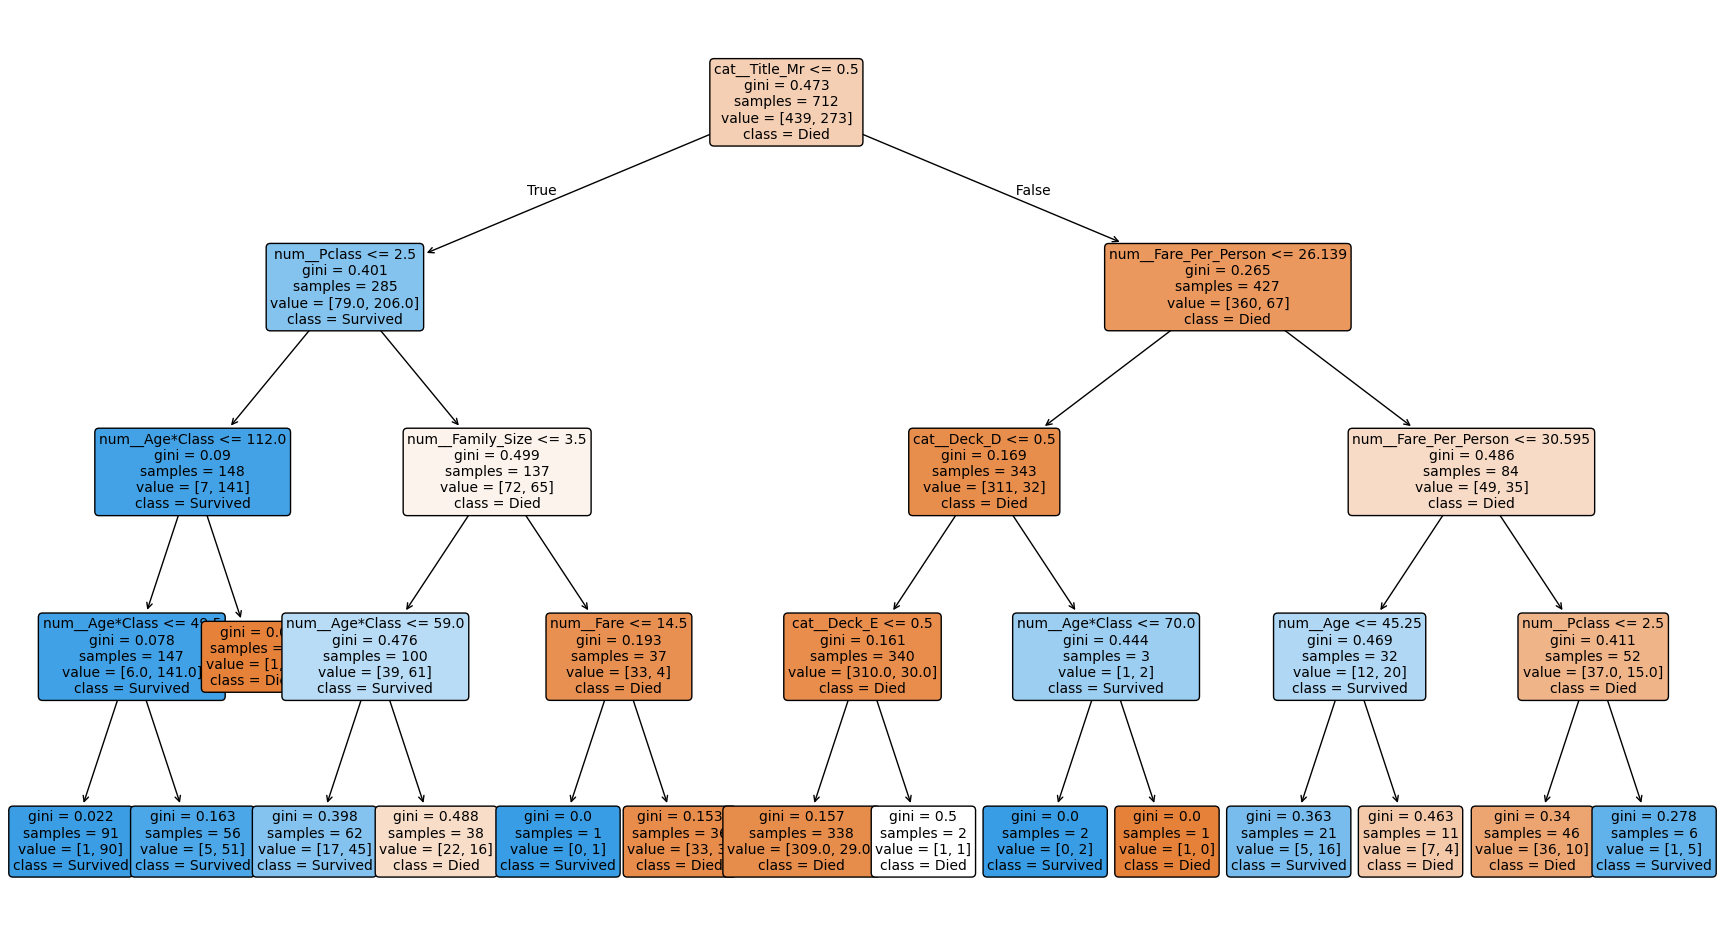

In [57]:
#visualising the tree 
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(22, 12))

# Extract the trained decision tree inside the pipeline
model_tree = clf.named_steps['model']

# Extract feature names AFTER preprocessing
# (one-hot encoding expands categories, so we need transformed names)
feature_names = clf.named_steps['preprocess'].get_feature_names_out()

tree.plot_tree(
    model_tree,
    feature_names=feature_names,
    class_names=['Died', 'Survived'],
    filled=True,
    rounded=True,
    fontsize=10
)

plt.show()

In [69]:
#simply replace the model step with a randomforest 

from sklearn.ensemble import RandomForestClassifier

clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=None, #we are letting them grow fully because we can
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    ))
])

#retrain + evaluate 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)

print("Validation Accuracy:", accuracy_score(y_valid, y_pred))
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

#let's also see which engineered features actually matter.

model_rf = clf.named_steps['model']
feature_names = clf.named_steps['preprocess'].get_feature_names_out()

importances = model_rf.feature_importances_
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

feat_imp.head(20)


Validation Accuracy: 0.8156424581005587

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85       110
           1       0.77      0.74      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



,feature,importance
6,num__Fare_Per_Person,0.130488
5,num__Age*Class,0.125084
3,num__Fare,0.112054
0,num__Age,0.105563
11,cat__Title_Mr,0.093844
15,cat__Sex_male,0.085712
14,cat__Sex_female,0.081891
7,num__Pclass,0.042990
4,num__Family_Size,0.041128
27,cat__Deck_Unknown,0.030466


In [65]:
#the random forest did not work particularly better so if training accuracy is better
#than validation accuracy, that means we are overfitting 

y_train_pred = clf.predict(X_train)
print("Train acc:", accuracy_score(y_train, y_train_pred))
print("Valid acc:", accuracy_score(y_valid, y_pred))

Train acc: 0.9859550561797753
Valid acc: 0.8156424581005587


In [71]:
#it is overfitting clearly. let's limit max depth to 10
clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=10, #we are letting them grow fully because we can
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

#retrain + evaluate 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)

print("Validation Accuracy:", accuracy_score(y_valid, y_pred))
print("\nClassification Report:\n", classification_report(y_valid, y_pred))


Validation Accuracy: 0.8100558659217877

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       110
           1       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



In [78]:
#doesnt change much. so lets use CV which is better than a single
#train test split because A single split is too noisy.
#Cross-validation averages out the noise.

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

tree_clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', DecisionTreeClassifier(
        max_depth=4,
        random_state=42
    ))
])

rf_clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    ))
])

scores_tree = cross_val_score(tree_clf, X, y, cv=5, scoring='accuracy')
scores_rf   = cross_val_score(rf_clf,   X, y, cv=5, scoring='accuracy')

print("Tree: mean =", scores_tree.mean(), ", std =", scores_tree.std())
print("RF:   mean =", scores_rf.mean(),   ", std =", scores_rf.std())

#scores_tree = 5 accuracies, one per fold.
#scores_rf = 5 accuracies, one per fold.
#The mean tells you “average performance across many 
#splits”.
#The std tells you how much it jumps around across
#splits (stability).

#If both means are like 0.83 vs 0.84 with std ≈ 0.02, 
#they’re basically equally good; 
#i've hit the data limit, not a model limit.

Tree: mean = 0.8294017952419811 , std = 0.026984608646067713
RF:   mean = 0.8148327160881299 , std = 0.03783912472717499


In [ ]:
#With the current feature engineering and preprocessing,
#a shallow decision tree already captures most of the 
#signal in the Titanic dataset. The random forest did 
#not deliver a clear improvement: it achieved very high
#training accuracy but only similar (or slightly worse) 
#validation and cross-validated accuracy compared to the
#tree. This tells me I’ve hit the limits of what this 
#dataset and these features can provide, rather than 
#the limits of the specific algorithm. Cross-validation
#confirms that both models sit in roughly the same 
#accuracy band, and small differences are within the 
#noise of having fewer than a thousand samples.

#The main takeaway is that good feature engineering, 
#careful regularisation (max_depth, min_samples_leaf), 
#and proper evaluation (cross-validation instead of a 
#single split) matter more here than chasing a “fancier”
#model. To push performance meaningfully beyond this 
#point, I would need either more informative data, 
#stronger feature ideas, or a different modelling 
#approach (e.g. tuned gradient boosting) rather than 
#expecting random forests alone to magically fix the 
#ceiling.